### Data Preprocessing & Visualization

In [33]:
# Necessary imports
import pandas as pd

In [34]:
# Read our data
btc_2017_df = pd.read_csv("data/BTC-2017min.csv")
btc_2018_df = pd.read_csv("data/BTC-2018min.csv")
btc_2019_df = pd.read_csv("data/BTC-2019min.csv")
btc_2020_df = pd.read_csv("data/BTC-2020min.csv")
btc_2021_df = pd.read_csv("data/BTC-2021min.csv")

In [35]:
# Concatendate the data while reversing the dataframes (Originally in dataframe 31-12 -> 01-01, we want 01-01 -> 31-12)
btc_df = pd.concat([btc_2017_df.iloc[::-1], btc_2018_df.iloc[::-1], btc_2019_df[::-1], btc_2020_df[::-1], btc_2021_df[::-1]], axis=0)

# Let's see the data
print("Head: ", btc_df.head())
print("Tail: ", btc_df.tail())

Head:                unix                 date   symbol    open    high     low  \
525598  1483228860  2017-01-01 00:01:00  BTC/USD  966.34  966.34  966.34   
525597  1483228920  2017-01-01 00:02:00  BTC/USD  966.16  966.37  966.16   
525596  1483228980  2017-01-01 00:03:00  BTC/USD  966.37  966.37  966.37   
525595  1483229040  2017-01-01 00:04:00  BTC/USD  966.37  966.37  966.37   
525594  1483229100  2017-01-01 00:05:00  BTC/USD  966.43  966.43  966.43   

         close  Volume BTC   Volume USD  
525598  966.34    7.610000  7353.847400  
525597  966.37    8.087376  7815.397864  
525596  966.37    0.000000     0.000000  
525595  966.37    0.000000     0.000000  
525594  966.43    0.107000   103.408010  
Tail:           unix                 date   symbol      open      high       low  \
4  1646105880  2022-03-01 03:38:00  BTC/USD  43077.82  43077.82  43049.46   
3  1646105940  2022-03-01 03:39:00  BTC/USD  43035.16  43035.16  42999.44   
2  1646106000  2022-03-01 03:40:00  BTC/USD  4

In [36]:
# Remove unneded columns (symbol not needed)
btc_df = btc_df.drop(['unix', 'symbol'], axis=1)

In [37]:
# Simplify names
btc_df.columns = ['date', 'open', 'high', 'low', 'close', 'volume_btc', 'volume_usd']

In [38]:
# Necessary import for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
# Reindex all dates
btc_df.index = pd.DatetimeIndex(btc_df['date'])
all_minutes = pd.date_range(btc_df.index.min(), btc_df.index.max(), freq="T")
btc_df = btc_df.reindex(all_minutes)

In [40]:
# Checking for missing data
btc_df.isna().sum()

date          39322
open          39322
high          39322
low           39322
close         39322
volume_btc    39322
volume_usd    39322
dtype: int64

In [41]:
# We found some missing values -> let's fill them in
btc_df['date'] = btc_df.index
btc_df['open'] = btc_df['open'].interpolate()
btc_df['high'] = btc_df['high'].interpolate()
btc_df['low'] = btc_df['low'].interpolate()
btc_df['close'] = btc_df['close'].interpolate()
btc_df['volume_btc'] = btc_df['volume_btc'].interpolate()
btc_df['volume_usd'] = btc_df['volume_usd'].interpolate()

In [42]:
# Check if all missing values are filled in
btc_df.isna().sum()

date          0
open          0
high          0
low           0
close         0
volume_btc    0
volume_usd    0
dtype: int64

In [43]:
# Smoothing data / Resampling -> Downsampling (Minutes to Days)
btc_df_downsample = btc_df[['date', 'open', 'high', 'low', 'close', 'volume_btc', 'volume_usd']].resample('D', on='date').mean().reset_index(drop=False)
df = btc_df_downsample.copy()
df.shape

(1886, 7)

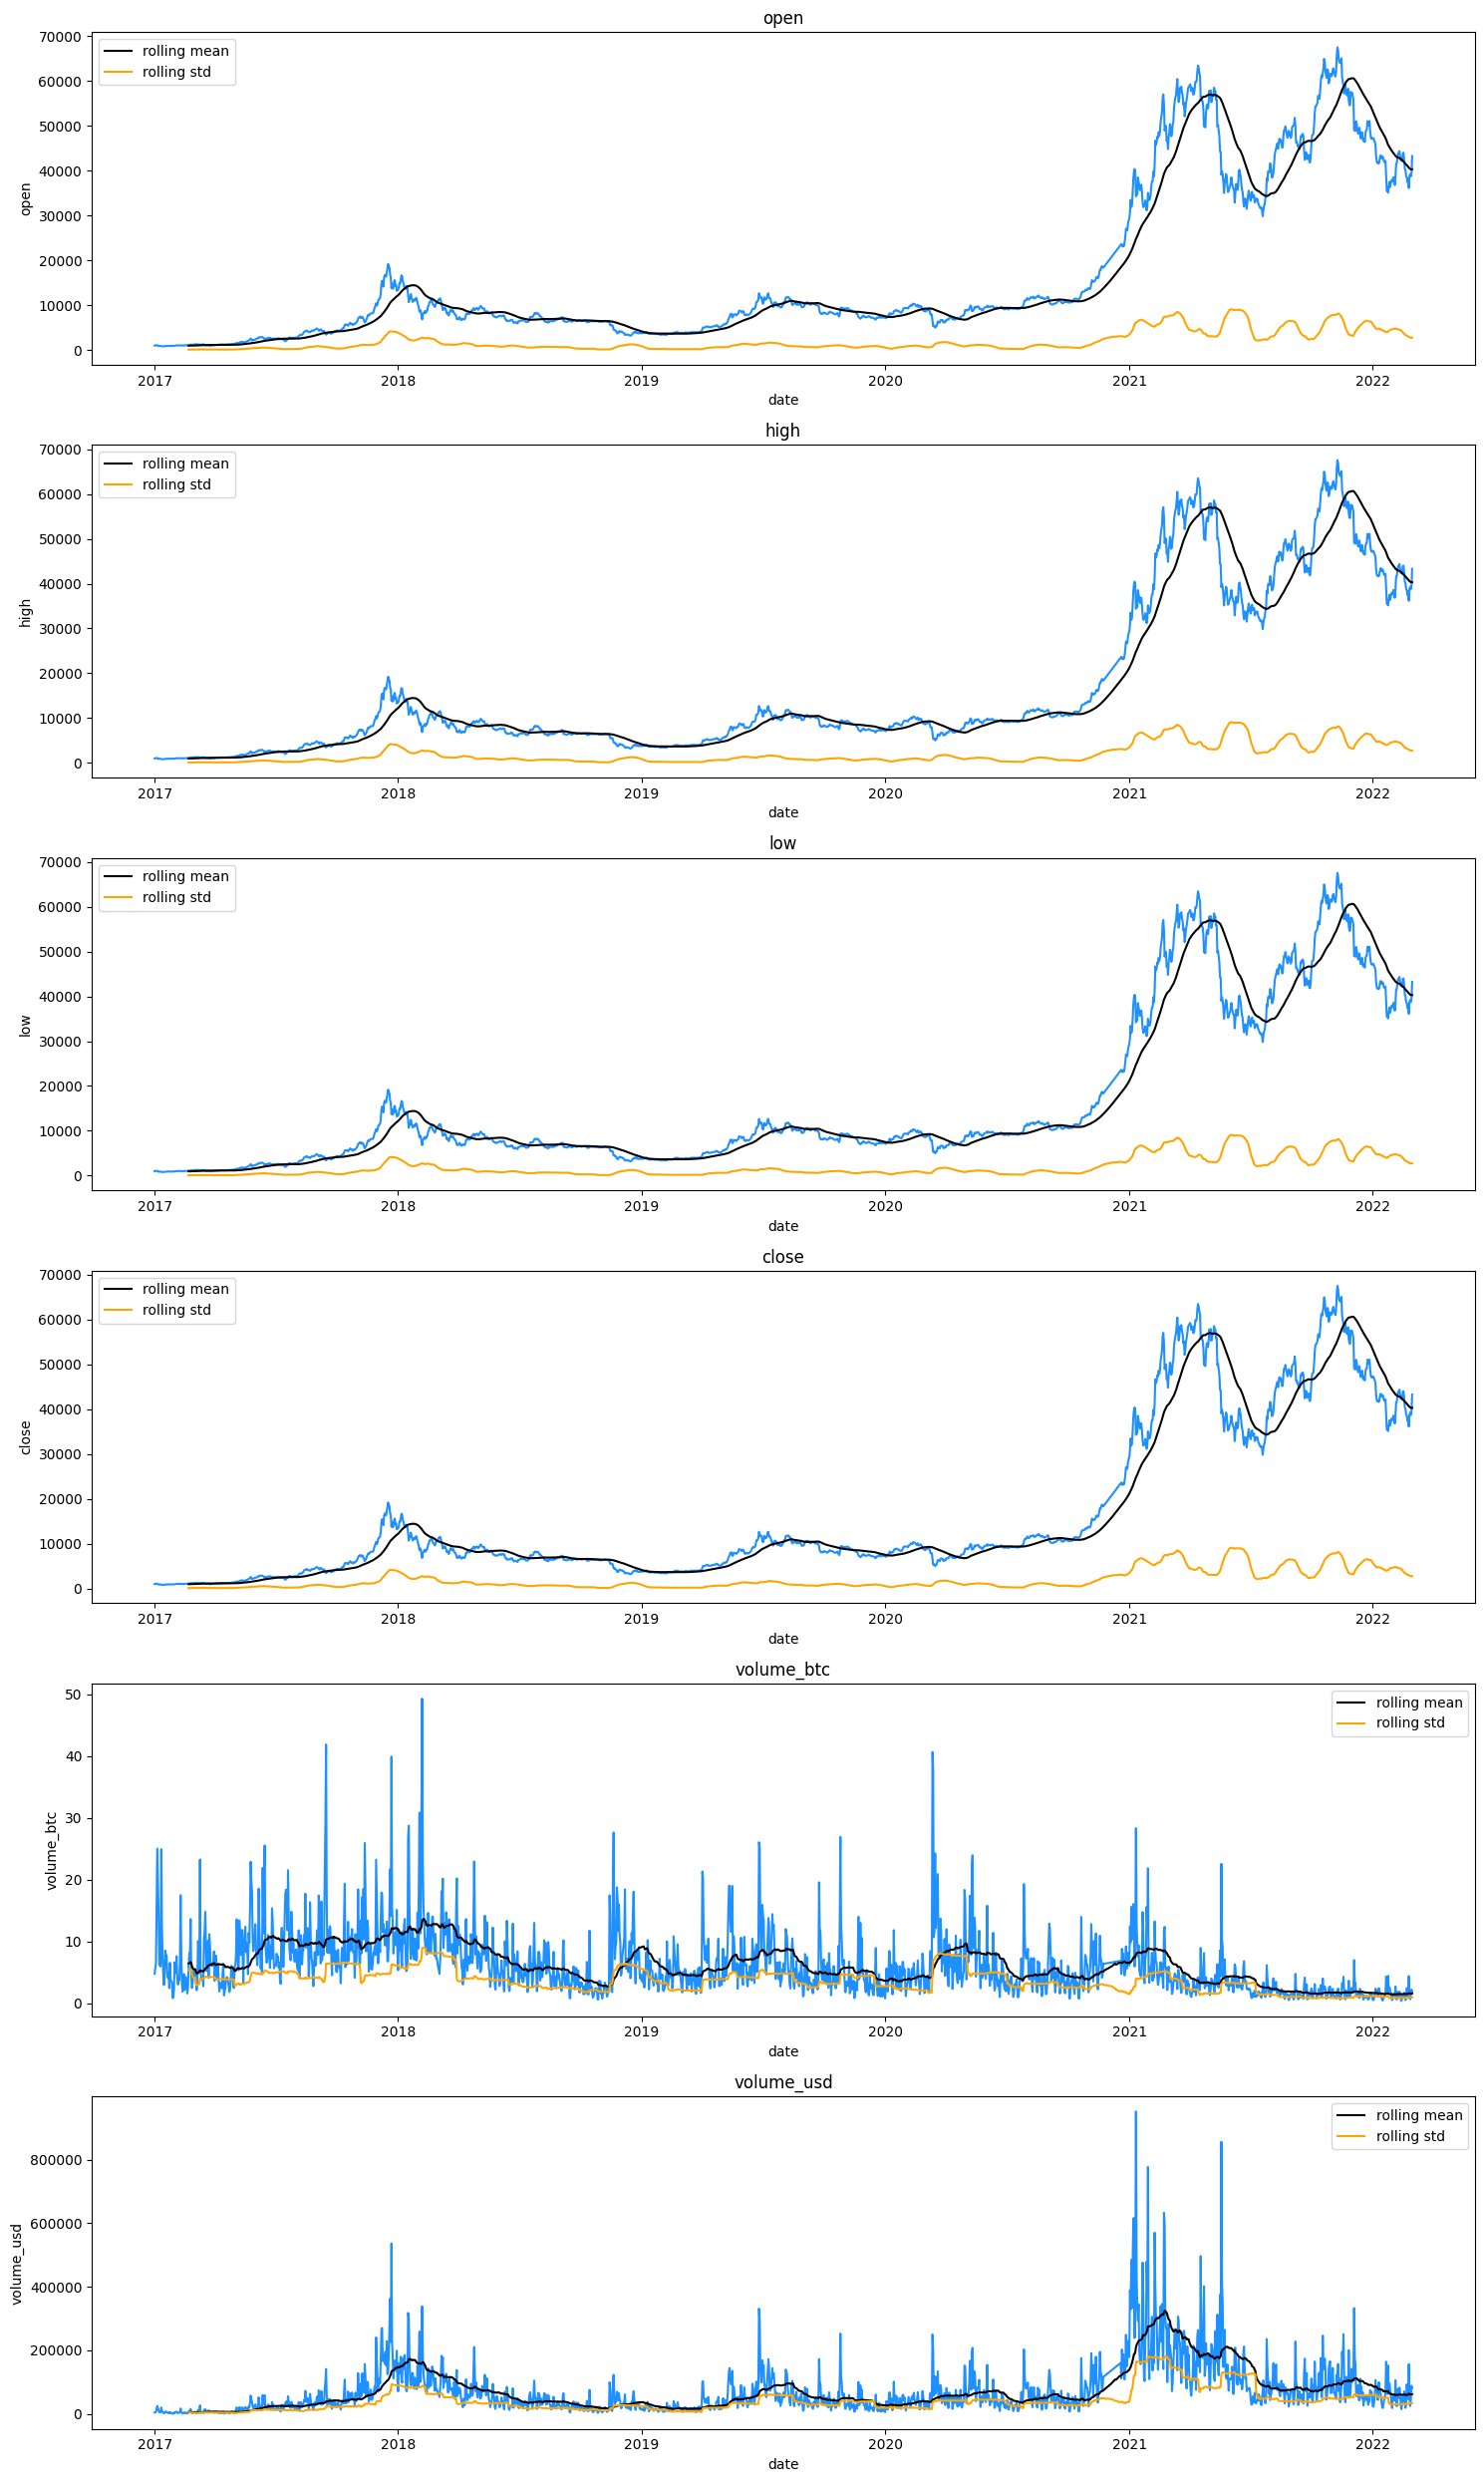

In [44]:
# Stationarity
# Visual

rolling_window = 52 # number of weeks in a year approx.

fig, ax = plt.subplots(nrows = 6, ncols = 1, figsize = (15, 25))

for i, column in enumerate(df.drop(['date'], axis = 1).columns):
    sns.lineplot(x=df['date'], y=df[column], ax=ax[i], color='dodgerblue')
    sns.lineplot(x=df['date'], y=df[column].rolling(rolling_window).mean(), ax=ax[i], color='black', label='rolling mean')
    sns.lineplot(x=df['date'], y=df[column].rolling(rolling_window).std(), ax=ax[i], color='orange', label='rolling std')
    ax[i].set_title(column)
    ax[i].set_ylabel(ylabel=column)

fig.tight_layout()

In [45]:
from statsmodels.tsa.stattools import adfuller

In [46]:
# Augmented Dickey-Fuller (ADF)
def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

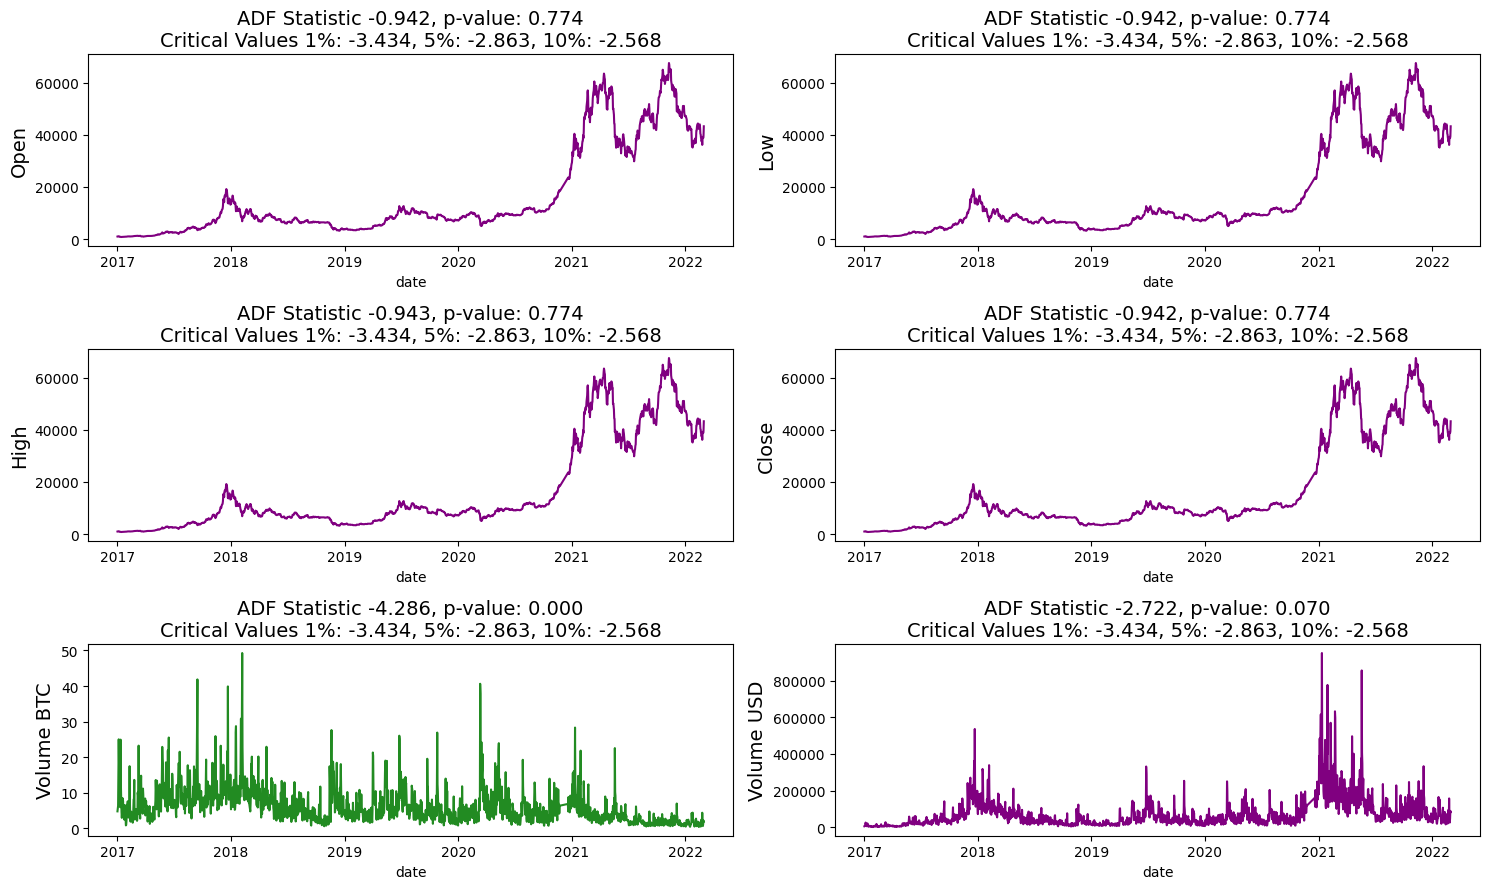

In [47]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

visualize_adfuller_results(df['open'].values, 'Open', ax[0, 0])
visualize_adfuller_results(df['high'].values, 'High', ax[1, 0])
visualize_adfuller_results(df['low'].values, 'Low', ax[0, 1])
visualize_adfuller_results(df['close'].values, 'Close', ax[1, 1])
visualize_adfuller_results(df['volume_btc'].values, 'Volume BTC', ax[2, 0])
visualize_adfuller_results(df['volume_usd'].values, 'Volume USD', ax[2, 1])

fig.tight_layout()

In [48]:
import numpy as np

/var/folders/5d/h_8336656hb0sql9hqtn3m400000gn/T/ipykernel_71483/625744993.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['close_log'], ax=ax[1])


<AxesSubplot:xlabel='close_log', ylabel='Density'>

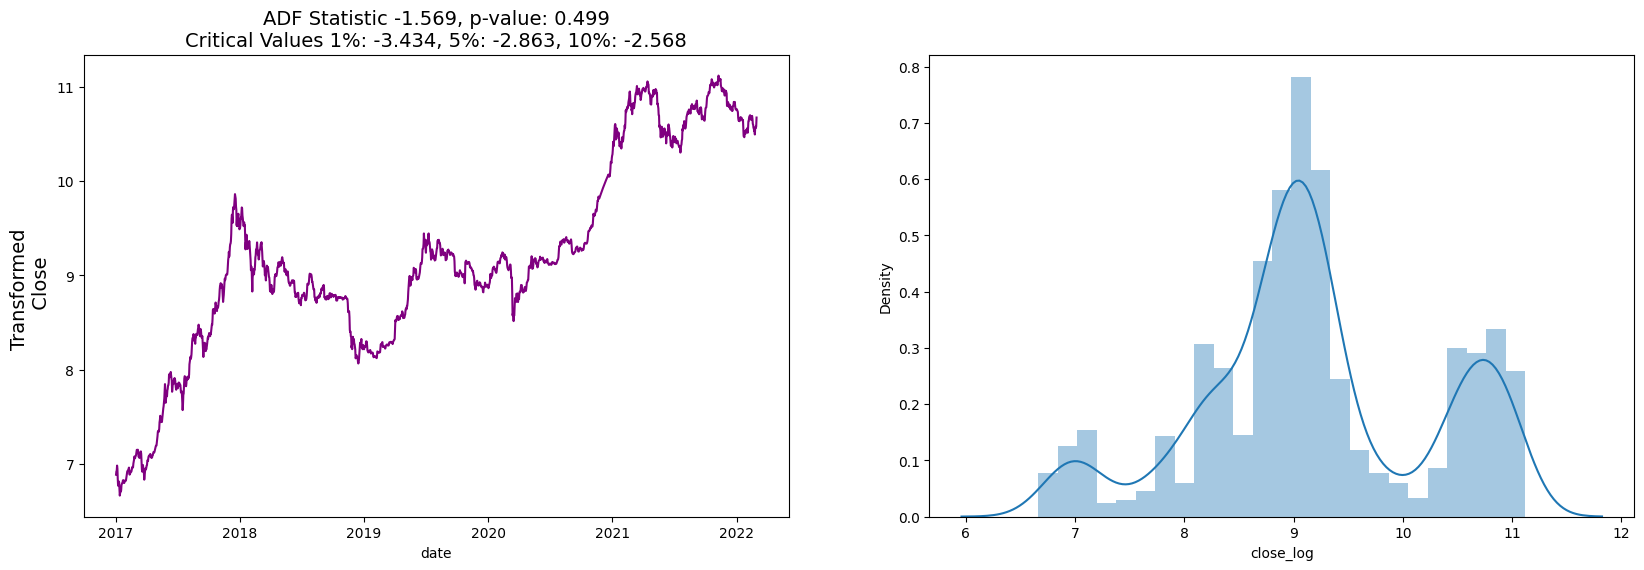

In [49]:
# Our features are NON-STATIONARY

# Stationary by transformation
df['close_log'] = np.log(abs(df['close']))

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
visualize_adfuller_results(df['close_log'], 'Transformed \n Close', ax[0])
sns.distplot(df['close_log'], ax=ax[1])

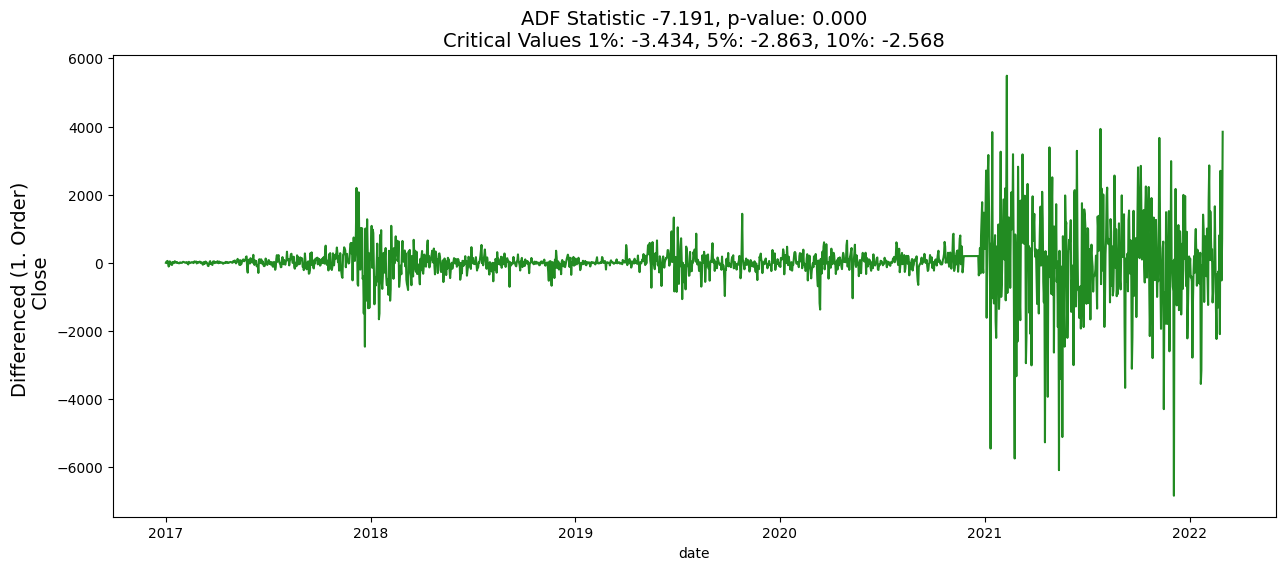

In [50]:
# Stationary by differencing
ts_diff = np.diff(df['close'])
df['close_diff_1'] = np.append([0], ts_diff)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df['close_diff_1'], 'Differenced (1. Order) \n Close', ax)

In [51]:
# Feature engineering
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day
df['day_of_year'] = pd.DatetimeIndex(df['date']).dayofyear
df['week_of_year'] = pd.DatetimeIndex(df['date']).weekofyear
df['quarter'] = pd.DatetimeIndex(df['date']).quarter
df['season'] = df['month'] % 12 // 3 + 1

df[['date', 'year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'season']].head()

/var/folders/5d/h_8336656hb0sql9hqtn3m400000gn/T/ipykernel_71483/4015462888.py:6: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week_of_year'] = pd.DatetimeIndex(df['date']).weekofyear


,date,year,month,day,day_of_year,week_of_year,quarter,season
0,2017-01-01,2017,1,1,1,52,1,1
1,2017-01-02,2017,1,2,2,1,1,1
2,2017-01-03,2017,1,3,3,1,1,1
3,2017-01-04,2017,1,4,4,1,1,1
4,2017-01-05,2017,1,5,5,1,1,1


<AxesSubplot:xlabel='date', ylabel='month'>

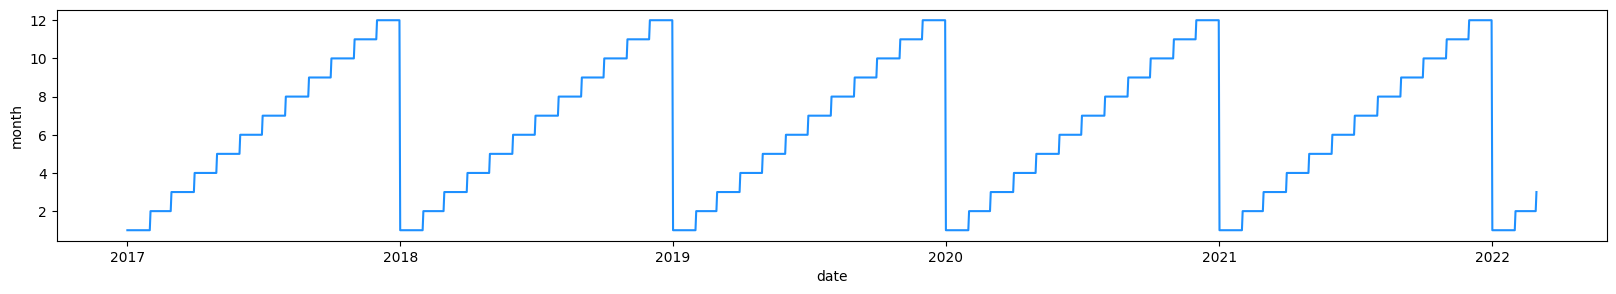

In [52]:
# Encode cyclical features
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))

sns.lineplot(x=df['date'], y=df['month'], color='dodgerblue')

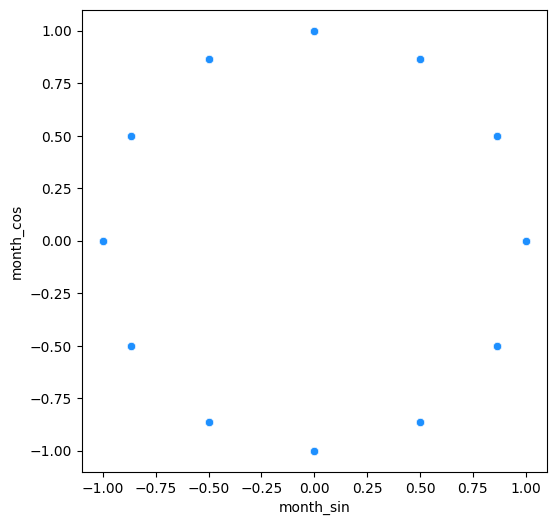

In [53]:
# By using sin and cos
month_in_year = 12
df['month_sin'] = np.sin(2*np.pi*df['month']/month_in_year)
df['month_cos'] = np.cos(2*np.pi*df['month']/month_in_year)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=df.month_sin, y=df.month_cos, color='dodgerblue')
plt.show()

In [54]:
# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

In [55]:
core_columns =  ['open', 'high', 'low', 'close', 'volume_btc', 'volume_usd']

for column in core_columns:
    decomp = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal

/var/folders/5d/h_8336656hb0sql9hqtn3m400000gn/T/ipykernel_71483/2264080965.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/5d/h_8336656hb0sql9hqtn3m400000gn/T/ipykernel_71483/2264080965.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


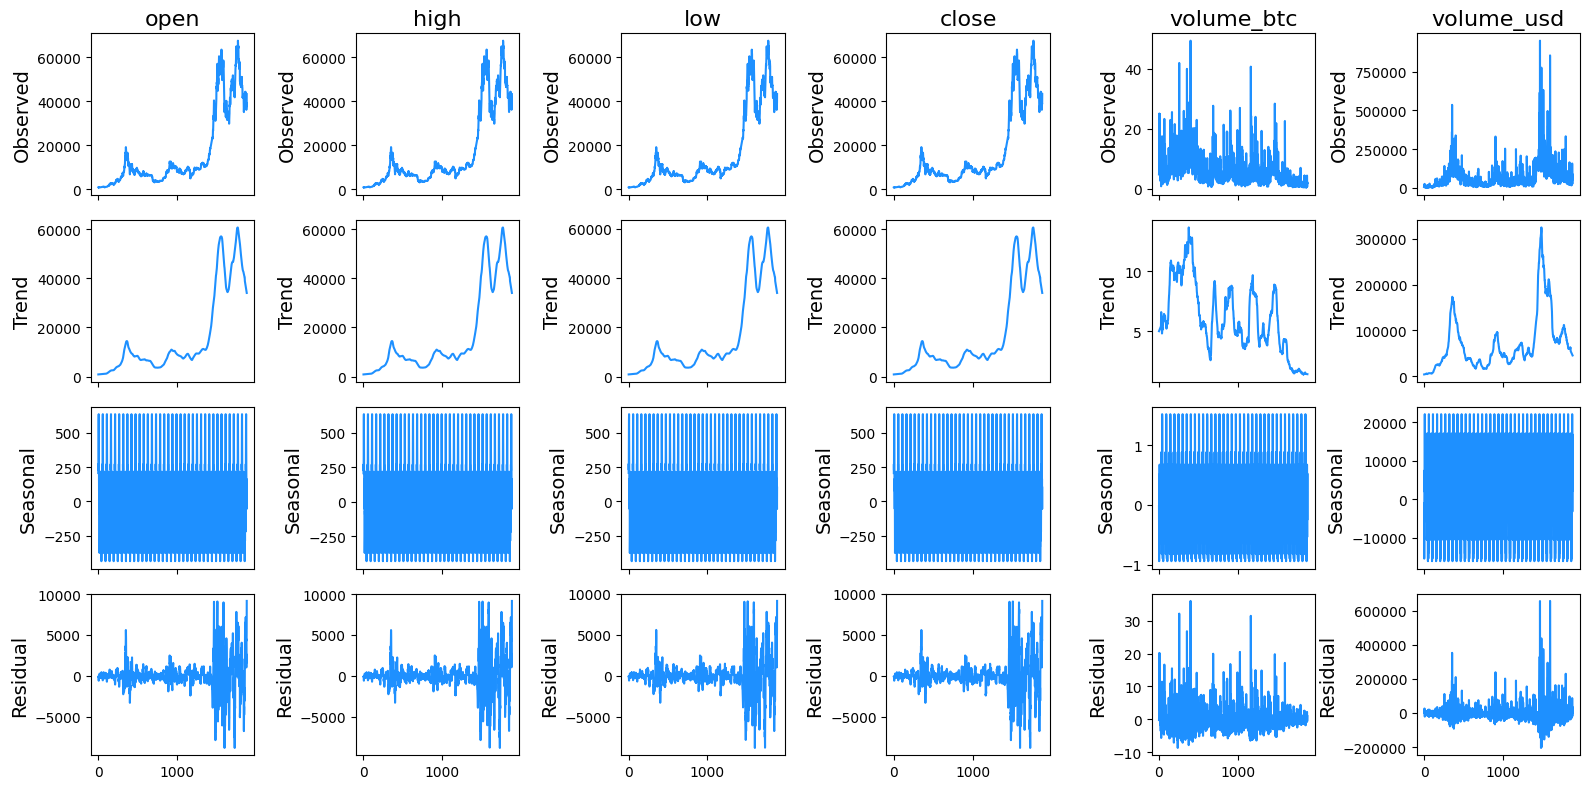

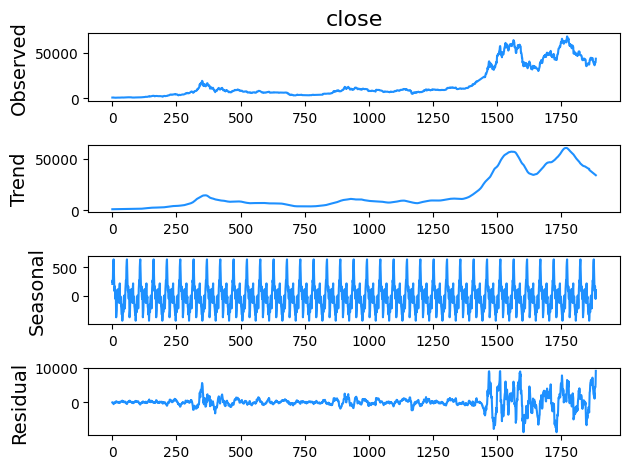

In [66]:
fig, ax = plt.subplots(ncols=6, nrows=4, sharex=True, figsize=(16,8))

for i, column in enumerate(['open', 'high', 'low', 'close', 'volume_btc', 'volume_usd']):
    
    res = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')

    ax[0,i].set_title('{}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False, color='dodgerblue')
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False, color='dodgerblue')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i], legend=False, color='dodgerblue')
    ax[3,i].set_ylabel('Residual', fontsize=14)

fig.tight_layout()
fig.show()

fig, ax = plt.subplots(ncols=1, nrows=4)
res = seasonal_decompose(df['close'], period=52, model='additive', extrapolate_trend='freq')
ax[0].set_title('{}'.format('close'), fontsize=16)
res.observed.plot(ax=ax[0], legend=False, color='dodgerblue')
ax[0].set_ylabel('Observed', fontsize=14)

res.trend.plot(ax=ax[1], legend=False, color='dodgerblue')
ax[1].set_ylabel('Trend', fontsize=14)

res.seasonal.plot(ax=ax[2], legend=False, color='dodgerblue')
ax[2].set_ylabel('Seasonal', fontsize=14)

res.resid.plot(ax=ax[3], legend=False, color='dodgerblue')
ax[3].set_ylabel('Residual', fontsize=14)

fig.tight_layout()
fig.show()

In [57]:
# Lag
weeks_in_month = 4

for column in ['open', 'high', 'low', 'close', 'volume_btc', 'volume_usd']:
    df[f'{column}_seasonal_shift_b_2m'] = df[f'{column}_seasonal'].shift(-2 * weeks_in_month)
    df[f'{column}_seasonal_shift_b_1m'] = df[f'{column}_seasonal'].shift(-1 * weeks_in_month)
    df[f'{column}_seasonal_shift_1m'] = df[f'{column}_seasonal'].shift(1 * weeks_in_month)
    df[f'{column}_seasonal_shift_2m'] = df[f'{column}_seasonal'].shift(2 * weeks_in_month)
    df[f'{column}_seasonal_shift_3m'] = df[f'{column}_seasonal'].shift(3 * weeks_in_month)

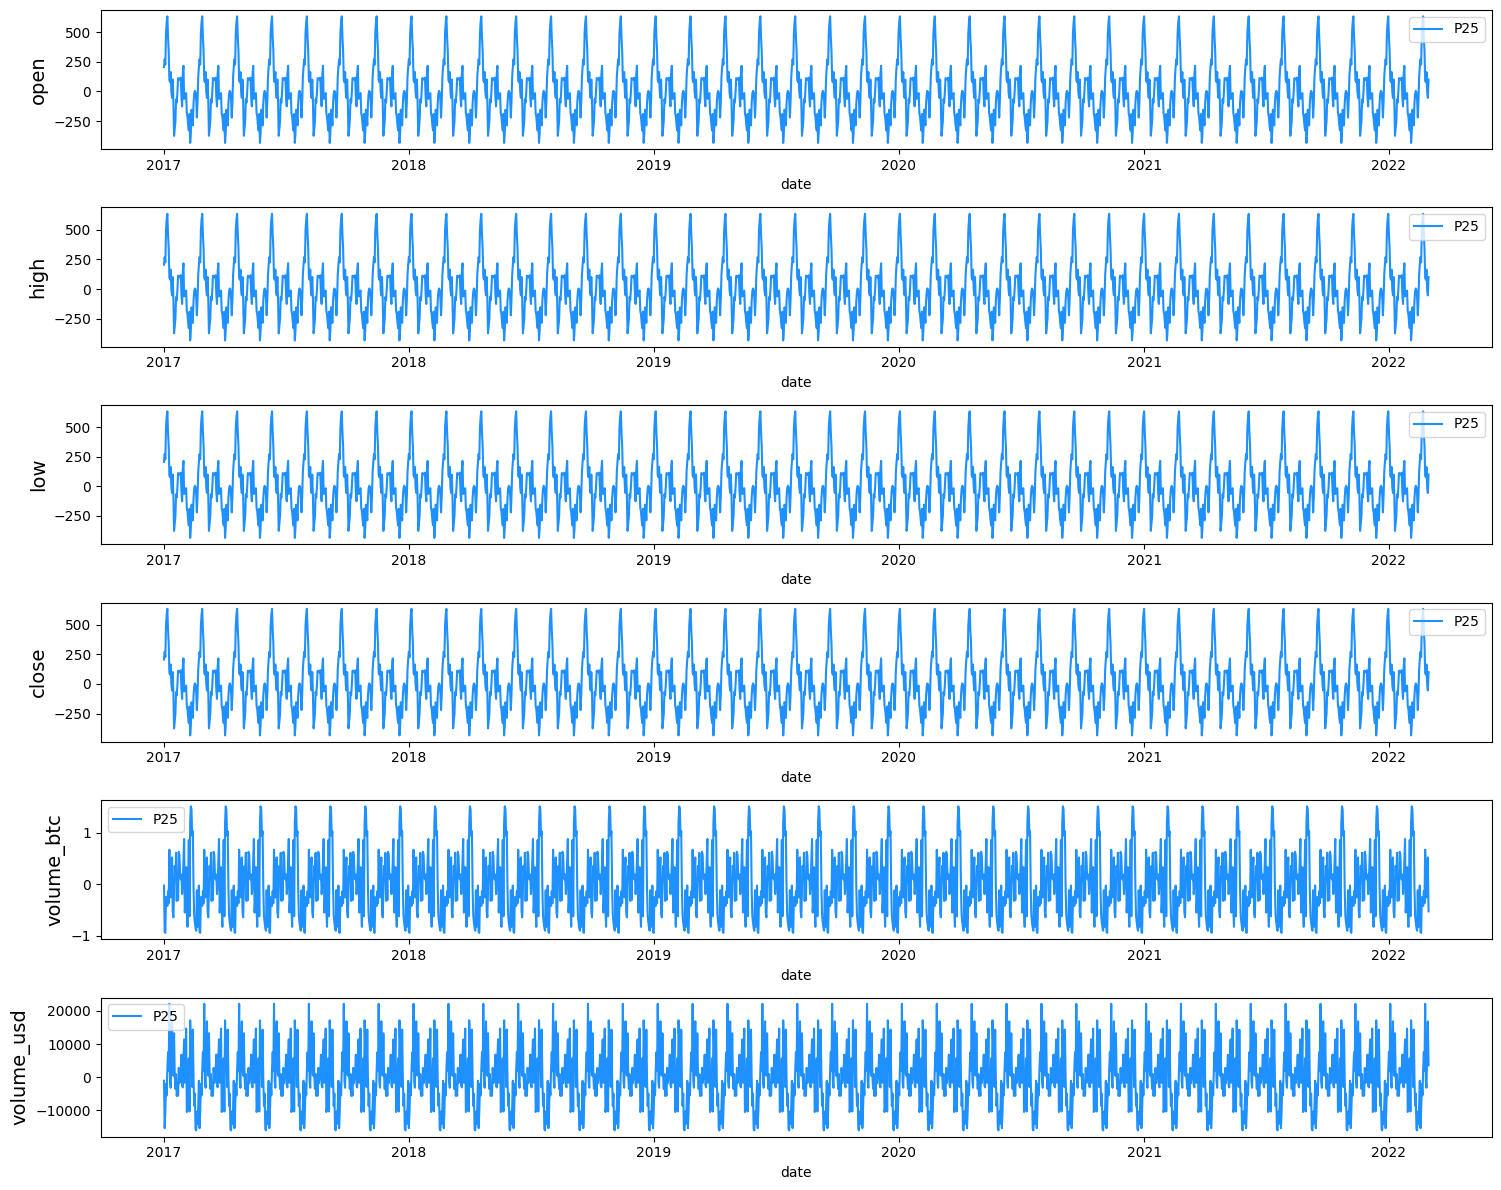

In [58]:
# Seasonal components of Features
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(15, 12))
f.suptitle('Seasonal Components of Features', fontsize=16)

for i, column in enumerate(['open', 'high', 'low', 'close', 'volume_btc', 'volume_usd']):
    sns.lineplot(x=df['date'], y=df[column + '_seasonal'], ax=ax[i], color='dodgerblue', label='P25')
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    
fig.tight_layout()

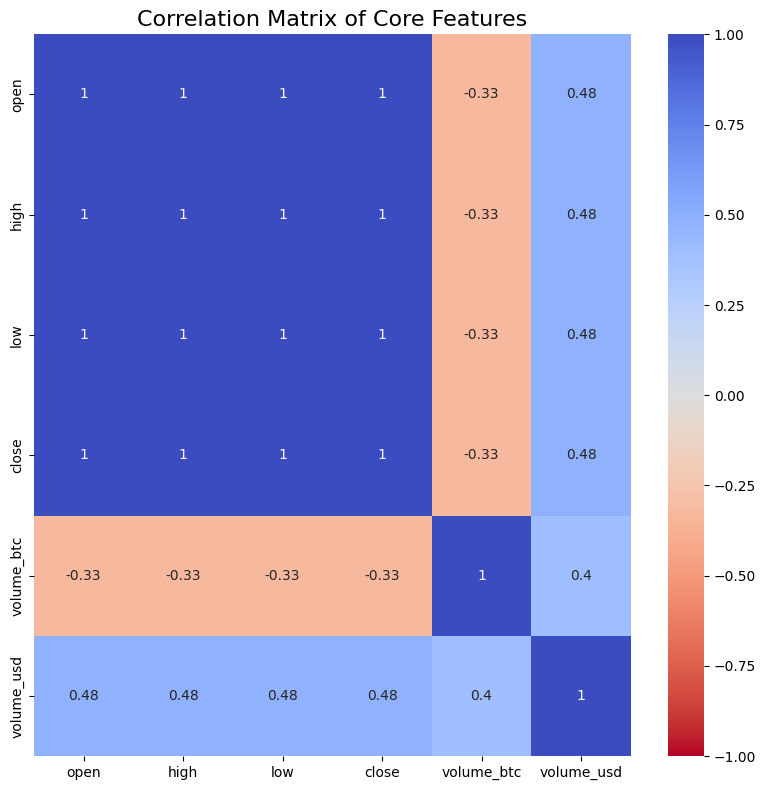

In [59]:
# Correlation matrix of core features
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

corrmat = df[['open', 'high', 'low', 'close', 'volume_btc', 'volume_usd']].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax)
ax.set_title('Correlation Matrix of Core Features', fontsize=16)

fig.tight_layout()

In [60]:
# Autocorrelation analysis
from pandas.plotting import autocorrelation_plot

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

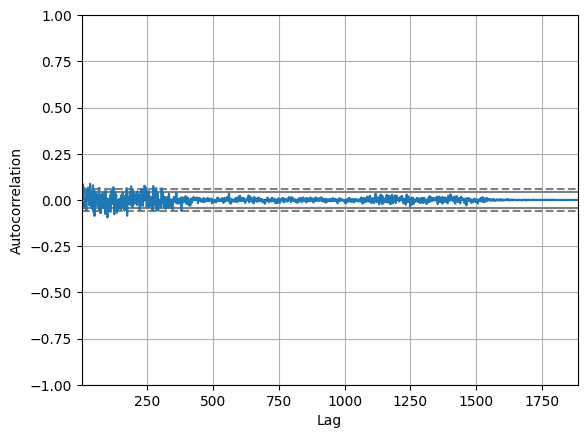

In [61]:
autocorrelation_plot(df['close_diff_1'])

In [62]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/Users/zane/Library/Python/3.9/lib/python/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/var/folders/5d/h_8336656hb0sql9hqtn3m400000gn/T/ipykernel_71483/1512367503.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


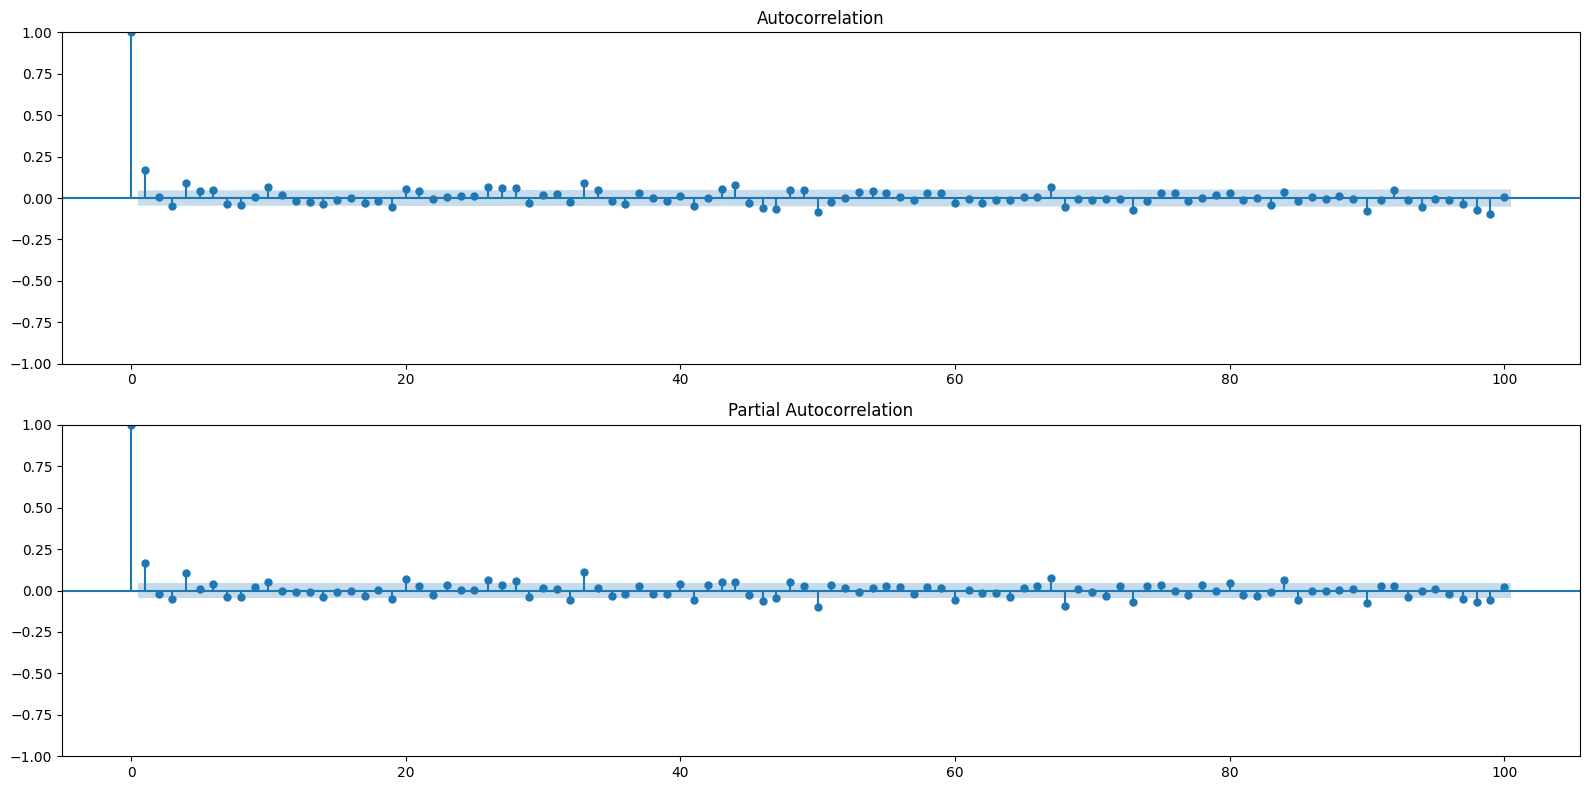

In [63]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(16, 8))

plot_acf(df['close_diff_1'], lags=100, ax=ax[0])
plot_pacf(df['close_diff_1'], lags=100, ax=ax[1])

fig.tight_layout()
fig.show()